In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Linear Regression as Gaussian Process

This material is taken (some of it verbatim) from the book <a href='http://www.gaussianprocess.org/gpml/chapters/'>_Gaussian Processes for Machine Learning_ by Rasmussen and Williams (2006)</a> (you can download chapters or the entire book by following the link).

**Definition 2.1** _A_ Gaussian process _is a collection of random variables, any finite number of which have a joint Gaussian distribution._

For a function (real process) $f(\mathbf{x})$, with expectation (mean) $m(\mathbf{x})$ and covariance function 
$$k(\mathbf{x},\mathbf{x}') = \mathbb{E}\left[(f(\mathbf{x}) - m(\mathbf{x}))(f(\mathbf{x}') - m(\mathbf{x}')\right]$$
we can write the Gaussian Process
$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}')).$$

Practically speaking, this means that if we believe our data has been drawn from a function 

Before jumping in with data, let's generate a prior on the function. We'll aim to recreate the function $f$ at 50 points, arranged into the matrix $X_*$ (in our 1D example, the matrix $X_*$ has size $1\times 50$, but the method generalizes to multiple dimensions). We will imagine our function $f$ has zero mean $m(\mathbf{x})=\mathbf{0}$ and it's covariance is the _squared exponential_ (Gaussian, rbf, ...so many names).
$$k(\mathbf{x},\mathbf{x}') = \exp\left(-\frac{1}{2}\|\mathbf{x} - \mathbf{x}'\|^2\right).$$
Now we can generate the covariance matrix (size $50\times50$) between our sampling points $K(X_*, X_*)$ whose $ij$th element is $k(\mathbf{x_i},\mathbf{x_j})$. Thus we can sample potential function values evaluated at $X_*$, $f_* = f(X_*)$, since
$$ f_* \sim \mathcal{N}(\mathbf{0}, K(X_*, X_*)),$$
as shown just below.

In [2]:
x_test = np.linspace(-5, 5)
K_test = np.array([[np.exp(-0.5 * (x1-x2)**2) for x1 in x_test] for x2 in x_test])
f_prior = np.random.multivariate_normal(np.zeros_like(x_test), K_test, 3)

/Users/skachuck/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


Numpy believes the covariance matrix is not positive semi-definite because of numerical error (the test points are too close together). To get rid of this error we could sample at fewer points.

All the same, the sampling has worked and we can view a few of these test functions below and the 95% confidence range for output values.

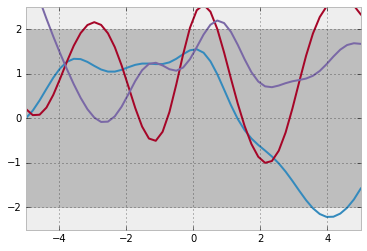

In [3]:
for line in f_prior:
    plt.plot(x_test, line)
plt.fill_between(x_test, -2, 2, color='k', alpha=0.2);
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

Note how smooth these appear. In fact, the squared exponential covariance function is infinitely differentiable, leading to a process that is infinitely mean-square differentiable (don't know what this means; see, apparently section 4.1). The functions have a characteristic length of about 1 unit, which comes directly from the squared exponential covariance.

## Prediction with Noise-free Observations

Imagine that we are now able to perfectly test our function at five random locations $X$ (shown below)

In [4]:
x_obs = np.random.choice(x_test, 5)
K_obs = np.array([[np.exp(-0.5 * (x1-x2)**2) for x1 in x_obs] for x2 in x_obs])
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K_obs)

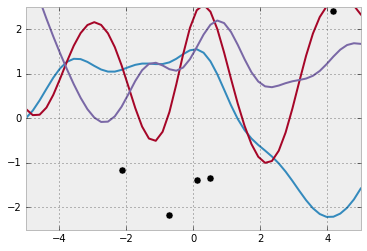

In [5]:
for line in f_prior:
    plt.plot(x_test, line)
plt.scatter(x_obs, y_obs, c='k', s=50, zorder=100)
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

We could, in priciple, sample our prior distribution and reject any distribution that doesn't go through our measured points exactly, but we have a much better way! Since $f(\mathbf{x})$ is a Gaussian Process, we know that the values $f = f(X)$ and the wanted values $f_*$ have a joint distribution
$$\left[ \begin{matrix}f \\ f_*\end{matrix}\right] \sim \mathcal{N}\left(\mathbf{0}, \left[ \begin{matrix}K(X,X) & K(X,X_*)\\ K(X_*,X) & K(X_*,X_*) \end{matrix}\right]\right).$$

This allows us to discover the posterior probability distribution of $f_*$ given a certain draw of $f$ as
$$f_* | X_*, X, f \sim \mathcal(K(X_*,X)K(X,X)^{-1}f, K(X_*, X_*) - K(X_*, X)K(X,X)^{-1}K(X,X_*))$$
via some fancy properties of joint Gaussian distributions.

We therefore have all we need to make some draws from this posterior distribution of desired function values, as shown below.


In [6]:
K_obs_test = np.array([[np.exp(-0.5 * (x1-x2)**2) for x1 in x_obs] for x2 in x_test])
Kinv = np.linalg.inv(K_obs)
f_post_mean = K_obs_test.dot(Kinv.dot(y_obs))
f_post_cov = K_test - K_obs_test.dot(Kinv.dot(K_obs_test.T))

/Users/skachuck/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


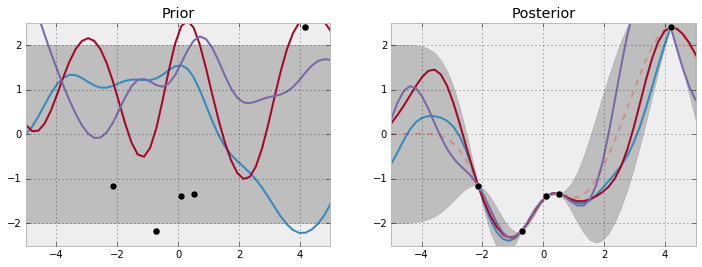

In [7]:
f_conditioned = np.random.multivariate_normal(f_post_mean, f_post_cov, 3)

fig, axs = plt.subplots(1,2, figsize=(12,4))

for line in f_prior:
    axs[0].plot(x_test, line)
axs[0].fill_between(x_test, -2, 2, color='k', alpha=0.2);
axs[0].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[0].set_xlim([-5, 5]); axs[0].set_ylim([-2.5, 2.5]); axs[0].set_title('Prior');

for line in f_conditioned:
    axs[1].plot(x_test, line)

post_stds = np.sqrt(np.maximum(1e-12, f_post_cov.diagonal()))
axs[1].fill_between(x_test, f_post_mean + 2*post_stds, 
                            f_post_mean - 2*post_stds, color='k', alpha=0.2)
axs[1].plot(x_test, f_post_mean, c='r', ls='--', alpha=0.25)
axs[1].scatter(x_obs, y_obs, c='k', s=50, zorder=100)
axs[1].set_xlim([-5, 5]); axs[1].set_ylim([-2.5, 2.5]); axs[1].set_title('Posterior');

If there is some noise in our function, such that our observations are actually $y=f(\mathbf{x}) + \epsilon$, where $\epsilon\sim \mathcal{N}(0, \sigma_n^2)$, then the prior on the noisy observations becomes
$$\textrm{cov}(y_p, y_q) = k(\mathbf{x}_p, \mathbf{x}_q) + \sigma_n^2\delta_{pq}$$
or $\textrm{cov}(\mathbf{y}) = K(X,X) + \sigma_n^2I$, and the calculation proceeds exactly as before.

We summarie this process into the following algorithm.

## The Algorithm

In [8]:
def gp_regression(x_obs, y_obs, k, sigsq_noise, x_test):
    """Predictions and log marginal likelihood for Gaussian process regression.
    
    The implentation addresses the matrix inversion required using Cholesky 
    factorization. The log determinant required for the log marginal likelihood
    is computed from the Cholesky factor (for large n it may not be possible to 
    represent the determinant itself). The computational complexity is n^3/6 for
    the Cholesky decomposition and n^2/2 for solving the triangular systems.
    
    Inputs
    ------
    x_obs       : (nobs, ndim)
    y_obs       : (nobs)
    k           : covariance function
    siqsq_noise : float (noise of observations)
    x_test      : (npred, ndim)
        The inputs at which predictions are desired.
    """
    
    n = len(x_obs)
    K_obs = k(x_obs, x_obs)
    K_obs_test = k(x_obs, x_test)
    
    L = np.linalg.cholesky(K_obs + sigsq_noise * np.eye(n))
    
    # Predictive mean eq.
    alpha = np.linalg.lstsq(L.T, np.linalg.lstsq(L, y_obs)[0])[0]
    y_test_mean = K_obs_test.T.dot(alpha)
    
    # Predictive variance eq.
    v = np.linalg.lstsq(L, K_obs_test)[0]
    y_test_var = k(x_test, x_test) - v.T.dot(v)
    
    # Log marginal likelihood.
    logmarg = -0.5*y_obs.dot(alpha) - np.sum(L.diagonal()) - 0.5*n*np.log(2*np.pi)
    
    return y_test_mean, y_test_var, logmarg

In [9]:
def sq_exp_cov(x1, x2, l=1, sigsqf=1):
    x1 = np.atleast_2d(x1).T
    x2 = np.atleast_2d(x2).T
    li2 = 1./l**2
    cov = np.array([[sigsqf*np.exp(-0.5 * li2 * (xi-xj).dot((xi-xj))) for xi in x2] for xj in x1])
    return cov

In [10]:
y_test_mean, y_test_var, logmarg = gp_regression(x_obs, y_obs, sq_exp_cov, sigsq_noise=0.01, x_test=x_test)

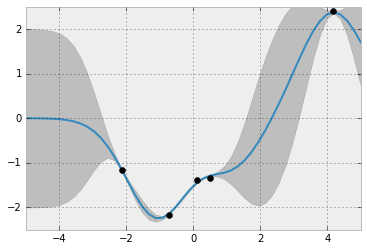

In [11]:
plt.plot(x_test, y_test_mean)
plt.plot(x_obs, y_obs, 'ko')
plt.fill_between(x_test, y_test_mean + 2*y_test_var.diagonal(), y_test_mean - 2*y_test_var.diagonal(), 
                 color='k', alpha=0.2)
plt.xlim([-5, 5]); plt.ylim([-2.5, 2.5]);

## Changing Hyperparameters - COMING!

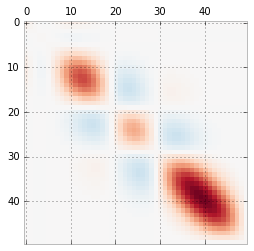

In [358]:
plt.matshow(y_test_var, cmap='RdBu_r', vmin=-1., vmax=1.)

In [307]:
logmarg

-53.233685082208218

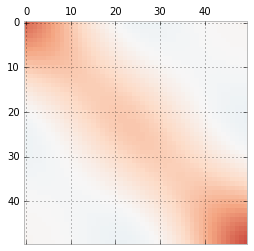

In [310]:
plt.matshow(y_test_var, cmap='RdBu_r', vmin=-1., vmax=1.)

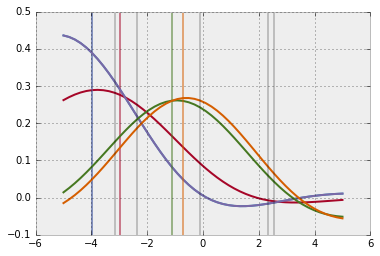

In [311]:
for n, c in zip(np.random.choice(np.arange(50), 5), plt.rcParams['axes.color_cycle']):
    plt.plot(x_test, y_test_var[n], color=c)
    plt.axvline(x_test[n], color=c, alpha=0.5)
for x in x_obs:
    plt.axvline(x, color='k', alpha=0.2)

## 2D Example - COMING

##Feature Space - COMING

##Experimental Design - COMING